In [3]:
import os
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import from_networkx
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.data import Dataset
from sklearn.model_selection import train_test_split
import copy

In [ ]:
# reading from second order neighbors file to build subgraphs in a list called sub_data_list
torch.manual_seed(1234567)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

folder_path = 'second_order_client_neighbors'
sub_data_list = []
client_number = []

for filename in os.listdir(folder_path):
    if filename.endswith('.gml'):
      
        file_path = os.path.join(folder_path, filename)
        g = nx.read_gml(file_path)

        subgraph_nodes = list(g.nodes)
        subgraph_nodes = [int(node) for node in subgraph_nodes]  # Convert to integer if they are not

        sub_edge_index, _ = subgraph(subgraph_nodes, data.edge_index, relabel_nodes=True)
        print(sub_edge_index.shape)

        sub_data = Data(x=data.x[subgraph_nodes], edge_index=sub_edge_index, y=data.y[subgraph_nodes])
        sub_data_list.append(sub_data)
        client_number.append(int(filename.split('.')[0].split('_')[1]))


In [5]:
# reading from second order test graph to build test graph called test_data
test_data = None

g = nx.read_gml('drive/MyDrive/federated_gnns_project/second_order_test_graph.gml')
subgraph_nodes = list(g.nodes)
subgraph_nodes = [int(node) for node in subgraph_nodes]  # Convert to integer if they are not
sub_edge_index, _ = subgraph(subgraph_nodes, data.edge_index, relabel_nodes=True)
test_data = Data(x=data.x[subgraph_nodes], edge_index=sub_edge_index, y=data.y[subgraph_nodes])



In [ ]:
# readingin in the facebook network to build a neighbors dictionary for each node
g = nx.read_gml('drive/MyDrive/federated_gnns_project/new_facebook_network.gml')
neighbors = {}

for node in g.nodes:
    neighbors[node] = list(g.neighbors(node))

print(neighbors)

In [7]:
# read new_facebook_network.gml and create a fully connected graph

neighbors_fully_connected = {}
for node in g.nodes:
    neighbors_fully_connected[node] = list(g.nodes)
    neighbors_fully_connected[node].remove(node)

In [8]:
print(sub_data_list[0])
print(sub_data_list[0].x.shape)
print(type(client_number))

Data(x=[59, 1433], edge_index=[2, 160], y=[59])
torch.Size([59, 1433])
<class 'list'>


In [9]:
#keep a list of training and validation loss per epoch for each subgraph
train_losses = []
val_losses = []

# Model Architectures

In [11]:
# GCN model
from torch_geometric.nn import GCNConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, 32)
        self.conv2 = GCNConv(32, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training) # p = 0.25
        x = self.conv2(x, edge_index)
        return x


model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)

In [12]:
#GAT model
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GATConv(num_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Train, Test, Validation, and Intial Training Methods

In [13]:
import matplotlib.pyplot as plt

def train(sub_data, model, optimizer, criterion):
      #put data on device
      sub_data = sub_data.to(device)
      model.train()
      optimizer.zero_grad()
      out = model(sub_data.x, sub_data.edge_index)  # Perform a single forward pass.
      loss = criterion(out, sub_data.y)  # Compute the loss solely based on the training nodes.
      loss.backward()
      optimizer.step()
      return loss

def train_batch(sub_data_loader, model, optimizer, criterion):
    for i, data in enumerate(sub_data_loader):
        x, edge_index, y, idx = data
        nodes = list(idx)
        sub_edge_index, _ = subgraph(nodes, edge_index[0], relabel_nodes=True)
        x = x.to(device)
        edge_index = edge_index.to(device)
        y = y.to(device)
        model.train()
        optimizer.zero_grad()
        out = model(x, sub_edge_index)
        loss = criterion(out, y)
        loss.backward(sub_edge_index)
        optimizer.step()
    return loss


def test(test_data, criterion, model):
      test_data = test_data.to(device)
      model.eval()
      out = model(test_data.x, test_data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred == test_data.y # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / len(test_data.y)  # Derive ratio of correct predictions.
      test_loss = criterion(out, test_data.y)  # Compute validation loss

      return test_loss, test_acc


def validate(test_data, model, criterion):
    test_data = test_data.to(device)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Do not compute gradients during this step
        out = model(test_data.x, test_data.edge_index)  # Forward pass
        pred = out.argmax(dim=1)  # Get predicted classes
        val_correct = pred == test_data.y # Compare with ground-truth
        val_loss = criterion(out, test_data.y)  # Compute validation loss
        val_acc = int(val_correct.sum()) / int(len(test_data.y))  # Compute validation accuracy
    return val_loss.item(), val_acc  # Return validation loss and accuracy

# initial training doesn't account for communication
def initial_training(epochs, learning_rate):
    test_losses = []
    test_accs = []
    dictionary_t_1 = {}
    dictionary_t = {}

    for i in range(len(sub_data_list)):
        sub_data = sub_data_list[i]
        model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()
        train_losses = []
        val_losses = []

        # Training loop for each epoch (adjust the range as needed)
        for epoch in range(1, epochs + 1):
            train_loss = train(sub_data, model, optimizer, criterion)  # Assuming 'train' returns a loss
            val_loss, _ = validate(test_data, model, criterion)         # Assuming 'validate' returns a loss and something else (like accuracy)

            train_losses.append(train_loss)
            val_losses.append(val_loss)


        test_loss, test_acc = test(test_data, criterion, model)
        test_losses.append(test_loss.item())
        test_accs.append(test_acc)
        row = i // 10
        col = i % 10

        model_weights = model.state_dict()
        client_number_num = client_number[i]
        dictionary_t_1[client_number_num] = model_weights

    return dictionary_t_1, test_losses, test_accs

## Aggregation Techniques

In [14]:
def fed_avg(models):
    global_model = copy.deepcopy(models[0]) # start with the first model
    for k in global_model.keys():
        global_model[k] = torch.stack([model[k].float() for model in models], 0).mean(0)
    return global_model

In [15]:
import numpy as np
def weighted_fed_avg(models, accuracies):
    #model and accuracies are dictionaries
    accuracies = np.exp(accuracies)
    global_model = copy.deepcopy(models[0]) # start with the first model
    for k in global_model.keys():
        weighted_sum = 0
        for i in range(len(models)):
            weighted_sum += accuracies[i] * models[i][k].float()
        global_model[k] = weighted_sum / sum(accuracies)
    return global_model

In [16]:
#rank based weighted average

def rank_based_weighted_avg(models, accuracies):
    global_model = copy.deepcopy(models[0]) # start with the first model
    accuracies = np.array(accuracies)
    sorted_indices = np.argsort(accuracies)
    for k in global_model.keys():
        weighted_sum = 0
        for i in range(len(models)):
            weighted_sum += (len(models) - np.where(sorted_indices == i)[0][0]) * models[i][k].float()
        global_model[k] = weighted_sum / sum(range(1, len(models) + 1))
    return global_model

In [17]:
def exponential_weighted_fed_avg(models, accuracies):
    accuracies = np.exp(accuracies) / np.sum(np.exp(accuracies))
    global_model = copy.deepcopy(models[0]) # start with the first model
    for k in global_model.keys():
        weighted_sum = 0
        for i in range(len(models)):
            weighted_sum += accuracies[i] * models[i][k].float()
        global_model[k] = weighted_sum / sum(accuracies)
    return global_model

In [18]:
def normalized_fed_avg(models, accuracies):
    global_model = copy.deepcopy(models[0])
    normalized_accuracies = [float(i)/sum(accuracies) for i in accuracies]
    for k in global_model.keys():
        weighted_sum = 0
        for i in range(len(models)):
            weighted_sum += normalized_accuracies[i] * models[i][k].float()
        global_model[k] = weighted_sum
    return global_model

In [19]:
#threshold based weighted average

def threshold_based_weighted_avg(models, accuracies, threshold):
    global_model = copy.deepcopy(models[0]) # start with the first model
    accuracies_copy = copy.deepcopy(accuracies)
    accuracies = np.array(accuracies)
    accuracies[accuracies < threshold] = 0
    #if all accuracies are below threshold, set threshold to current client's accuracy, which is first
    if np.sum(accuracies) == 0:
        threshold = accuracies_copy[0]
        accuracies_copy = np.array(accuracies_copy)
        accuracies_copy[accuracies_copy < threshold] = 0
        accuracies = accuracies_copy
    for k in global_model.keys():
        weighted_sum = 0
        for i in range(len(models)):
            weighted_sum += accuracies[i] * models[i][k].float()
        global_model[k] = weighted_sum / sum(accuracies)
    return global_model

In [20]:
def greedy_averaging(models, accuracies):
    #sort models by accuracy in descending order
    accuracies = np.array(accuracies)
    sorted_indices = np.argsort(accuracies)[::-1]
    sorted_models = []
    for i in range(len(models)):
        sorted_models.append(models[sorted_indices[i]])
    #start with the first model
    global_model = copy.deepcopy(sorted_models[0])
    #load weights into model
    model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    model.load_state_dict(global_model)
    test_accuracy = test(test_data, criterion, model)[1]
    #now, average with the next model, if accuracy improves, keep it, otherwise, discard it
    for i in range(1, len(models)):
        model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        new_weights = global_model.copy()
        for k in global_model.keys():
            new_weights[k] = (global_model[k] + sorted_models[i][k]) / 2
        model.load_state_dict(sorted_models[i])
        new_test_accuracy = test(test_data, criterion, model)[1]
        if new_test_accuracy > test_accuracy:
            global_model = new_weights
            test_accuracy = new_test_accuracy

    return global_model

## Communication Mechanisms

Broadcast Communication

In [21]:


def communication(dictionary_t_1_og, neighbors, epochs, rounds, learning_rate):
    # make a copy of dictionary_t_1
    test_losses = []
    test_accs = []

    dictionary_t_1 = dictionary_t_1_og.copy()
    dictionary_t = {}
    t_1_accuracies = {}
    for k in range(1, rounds + 1):

    # get the neighbprs of each client
        for i in range(len(sub_data_list)):
            sub_data = sub_data_list[i]
            model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
            model.load_state_dict(dictionary_t_1[client_number[i]])
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()
            train_losses = []
            val_losses = []

            # Training loop for each epoch (adjust the range as needed)
            for epoch in range(1, epochs + 1):
                train_loss = train(sub_data, model, optimizer, criterion)  # Assuming 'train' returns a loss
                val_loss, _ = validate(test_data, model, criterion)         # Assuming 'validate' returns a loss and something else (like accuracy)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

            test_loss, test_acc = test(test_data, criterion, model)
            if k == rounds:
                test_losses.append(test_loss.item())
                test_accs.append(test_acc)

            # add the model weights to the t -1 dictionary
            model_weights = model.state_dict()
            client_number_num = client_number[i]
            dictionary_t_1[client_number_num] = model_weights
            t_1_accuracies[client_number_num] = test_acc

        for i in range(100):
            client_number_num = client_number[i]
            # go through neighbors of client_number
            string_client_num = str(client_number_num)
            client_neighbors = neighbors[string_client_num]
            neighbors_state_dicts = []
            neighbors_state_dicts.append(dictionary_t_1[client_number_num])
            accuracies = []
            accuracies.append(t_1_accuracies[client_number_num])
            for j in range(len(client_neighbors)):
                # get model weights of neighbor
                neighbor_model = dictionary_t_1[int(client_neighbors[j])]
                neighbors_state_dicts.append(neighbor_model)
                accuracies.append(t_1_accuracies[int(client_neighbors[j])])

            #call fed_avg
            average_state_dict = {}
            average_state_dict = greedy_averaging(neighbors_state_dicts, accuracies)
            dictionary_t[client_number_num] = average_state_dict

        dictionary_t_1 = dictionary_t

    return test_losses, test_accs




In [23]:
def gossip_communication(dictionary_t_1_og, neighbors, epochs, rounds, learning_rate):
    # make a copy of dictionary_t_1
    test_losses = []
    test_accs = []

    dictionary_t_1 = dictionary_t_1_og.copy()
    dictionary_t = {}
    t_1_accuracies = {}
    for k in range(1, rounds + 1):

    # get the neighbprs of each client
        for i in range(len(sub_data_list)):
            sub_data = sub_data_list[i]

            model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
            model.load_state_dict(dictionary_t_1[client_number[i]])

            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()

            train_losses = []
            val_losses = []

            # Training loop for each epoch (adjust the range as needed)
            for epoch in range(1, epochs + 1):
                train_loss = train(sub_data, model, optimizer, criterion)  # Assuming 'train' returns a loss
                val_loss, _ = validate(test_data, model, criterion)         # Assuming 'validate' returns a loss and something else (like accuracy)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

            test_loss, test_acc = test(test_data, criterion, model)
            if k == rounds:
                test_losses.append(test_loss.item())
                test_accs.append(test_acc)

            # add the model weights to the t -1 dictionary
            model_weights = model.state_dict()
            client_number_num = client_number[i]
            dictionary_t_1[client_number_num] = model_weights
            t_1_accuracies[client_number_num] = test_acc

        for i in range(100):
            #each client sends its weights to a random neighbor, and that neighbor averages its weights with the received weights
            client_number_num = client_number[i]
            string_client_num = str(client_number_num)
            client_neighbors = neighbors[string_client_num]

            #pick a random neighbor
            random_neighbor = np.random.choice(client_neighbors)
            random_neighbor = int(random_neighbor)
            random_neighbor_state_dict_prev = dictionary_t_1[random_neighbor]
            average_state_dict = {}
            average_state_dict = fed_avg([dictionary_t_1[client_number_num], random_neighbor_state_dict_prev])
            models = [dictionary_t_1[client_number_num], random_neighbor_state_dict_prev]
            t_1_accuracies_list = [t_1_accuracies[client_number_num], t_1_accuracies[random_neighbor]]
            average_state_dict = fed_avg(models)
            dictionary_t_1[client_number_num] = average_state_dict
            dictionary_t[client_number_num] = average_state_dict

        dictionary_t_1 = dictionary_t

    return test_losses, test_accs

# Fully Connected Graph

## 1 epoch, 100 rounds

In [ ]:


dictionary_t_1, test_losses, test_accs = initial_training(1)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors_fully_connected, 1, 100)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  1.950941253900528
mean test accuracy before communication:  0.15015974440894567
mean test loss after communication:  2.0524680721759796
mean test accuracy after communication:  0.1924281150159743


## 5 epochs, 100 rounds

In [ ]:

dictionary_t_1, test_losses, test_accs = initial_training(5)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors_fully_connected, 5, 100)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.114197174310684
mean test accuracy before communication:  0.15220447284345034
mean test loss after communication:  2.6148978340625764
mean test accuracy after communication:  0.25000000000000006


## 10 epochs, 100 rounds

In [ ]:
dictionary_t_1, test_losses, test_accs = initial_training(10)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors_fully_connected, 10, 100)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.7938966619968415
mean test accuracy before communication:  0.15690095846645355
mean test loss after communication:  2.931734937429428
mean test accuracy after communication:  0.29412140575079876


# Our Social Network

## 1 epoch, 100 rounds

In [ ]:
dictionary_t_1, test_losses, test_accs = initial_training(1)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 1, 100)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  1.9492018187046052
mean test accuracy before communication:  0.15316293929712457
mean test loss after communication:  1.930002419948578
mean test accuracy after communication:  0.19610223642172536


## 5 epochs, 100 rounds

### Broadcast Communication

In [ ]:
#Using fedAvg technique 
dictionary_t_1, test_losses, test_accs = initial_training(5, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, 100, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.407359801530838
mean test accuracy before communication:  0.15399361022364202
mean test loss after communication:  2.557976485490799
mean test accuracy after communication:  0.32514376996805117


In [ ]:
#Using weighted fedAvg
dictionary_t_1, test_losses, test_accs = initial_training(5, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, 100, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.3787487030029295
mean test accuracy before communication:  0.15389776357827464
mean test loss after communication:  2.421589039564133
mean test accuracy after communication:  0.3638977635782748


In [ ]:
#Using threshold Based Avg
#Setting threshold to current client's most recent accuracy
dictionary_t_1, test_losses, test_accs = initial_training(5, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, 100, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.408725882768631
mean test accuracy before communication:  0.15600638977635767
mean test loss after communication:  2.1719933092594146
mean test accuracy after communication:  0.4841214057507986


In [ ]:
#Setting threshold to current client's most recent accuracy + 0.05
dictionary_t_1, test_losses, test_accs = initial_training(5, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, 100, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.411843087673187
mean test accuracy before communication:  0.15476038338658138
mean test loss after communication:  1.9223486149311066
mean test accuracy after communication:  0.4947603833865817


In [ ]:
#Greedy Averaging
dictionary_t_1, test_losses, test_accs = initial_training(5, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, 100, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.398931953907013
mean test accuracy before communication:  0.15402555910543117
mean test loss after communication:  2.1533005011081694
mean test accuracy after communication:  0.4891693290734826


### Gossip Communication

In [ ]:
# gossip and exponential averaging
dictionary_t_1, test_losses, test_accs = initial_training(5, 0.01)
test_losses, test_accs = gossip_communication(dictionary_t_1, neighbors, 5, 100, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test accuracy after communication: ", mean_test_accs)
print("mean test loss after communication: ", mean_test_losses)

mean test accuracy after communication:  0.3056230031948883
mean test loss after communication:  2.9699373984336854


In [ ]:
# gossip and normalized averaging
dictionary_t_1, test_losses, test_accs = initial_training(5, 0.01)
test_losses, test_accs = gossip_communication(dictionary_t_1, neighbors, 5, 100, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test accuracy after communication: ", mean_test_accs)
print("mean test loss after communication: ", mean_test_losses)

mean test accuracy after communication:  0.3449840255591053
mean test loss after communication:  2.6528512930870054


In [ ]:
# gossip and federated averaging
dictionary_t_1, test_losses, test_accs = initial_training(5, 0.01)
test_losses, test_accs = gossip_communication(dictionary_t_1, neighbors, 5, 100, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test accuracy after communication: ", mean_test_accs)
print("mean test loss after communication: ", mean_test_losses)

## 10 epochs, 100 rounds

In [ ]:
dictionary_t_1, test_losses, test_accs = initial_training(10, 0.01)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 10, 100, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  3.3138426327705384
mean test accuracy before communication:  0.16789137380191682
mean test loss after communication:  2.671199848651886
mean test accuracy after communication:  0.4253354632587859


## 20 epochs, 100 rounds

In [ ]:
dictionary_t_1, test_losses, test_accs = initial_training(20)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 20, 100)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  3.4152511596679687
mean test accuracy before communication:  0.1779233226837061
mean test loss after communication:  3.4955796611309053
mean test accuracy after communication:  0.2935463258785943


## 1 epochs, 10 rounds

In [ ]:
dictionary_t_1, test_losses, test_accs = initial_training(1)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 1, 10)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  1.9489406883716582
mean test accuracy before communication:  0.1485623003194888
mean test loss after communication:  1.9430880868434905
mean test accuracy after communication:  0.1542811501597442


## 5 epochs, 10 rounds

In [ ]:
dictionary_t_1, test_losses, test_accs = initial_training(5)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, 10)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.146751263141632
mean test accuracy before communication:  0.1514057507987219
mean test loss after communication:  2.396341060400009
mean test accuracy after communication:  0.15214057507987205


## 10 epochs, 10 rounds

In [ ]:
dictionary_t_1, test_losses, test_accs = initial_training(10)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 10, 10)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.69692032456398
mean test accuracy before communication:  0.1590095846645366
mean test loss after communication:  3.162060570716858
mean test accuracy after communication:  0.17827476038338652


## Fully Connected Graph Results
### (Training with original subgraphs)

| Epochs | Communication Rounds | Avg Test Accuracy (Before) | Avg Test Accuracy (After) | Avg Test Loss (Before) | Avg Test Loss (After) |
| ------ | -------------------- | -------------------------- | ------------------------- | ---------------------- | --------------------- |
| 1      | 100                  | 15.07%                     | 14.29%                    | 1.947                  | 2.083                 |
| 5      | 100                  | 14.89%                     | 15.49%                    | 2.021                  | 2.943                 |
| 10     | 100                  | 14.73%                     | 14.90%                    | 2.387                  | 5.010                 |



## Social Network Graph Results
### (Training with original subgraphs)

| Epochs | Communication Rounds | Avg Test Accuracy (Before) | Avg Test Accuracy (After) | Avg Test Loss (Before) | Avg Test Loss (After) |
| ------ | -------------------- | -------------------------- | ------------------------- | ---------------------- | --------------------- |
| 1      | 100                  | 15.13%                     | 14.31%                    | 1.947                  | 1.996                 |
| 1      | 10                   | 15.40%                     | 15.12%                    | 1.946                  | 1.945                 |
| 5      | 100                  | 14.38%                     | 16.16%                    | 2.028                  | 2.730                 |
| 5      | 10                   | 14.52%                     | 14.49%                    | 2.014                  | 2.282                 |
| 10     | 100                  | 14.74%                     | 16.07%                    | 2.321                  | 4.402                 |
| 10     | 10                   | 14.69%                     | 15.01%                    | 2.349                  | 3.084                 |
| 20     | 100                  | 15.39%                     | 18.50%                    | 3.101                  | 4.654                 |


## Fully Connected Graph Results
### (Training with second order subgraphs)


| Epochs | Communication Rounds | Avg Test Accuracy (Before) | Avg Test Accuracy (After) | Avg Test Loss (Before) | Avg Test Loss (After) |
| ------ | -------------------- | -------------------------- | ------------------------- | ---------------------- | --------------------- |
| 1      | 100                  | 15.02%                     | 19.24%                    | 1.951                  | 2.052                 |
| 5      | 100                  | 15.22%                     | 31.80%                    | 2.114                 | 2.614                |
| 10     | 100                  | 15.69%                     | 29.41%                    | 2.794                 | 2.932              |

## Social Network Graphs Results
### (Training with second order subgraphs)

| Epochs | Communication Rounds | Avg Test Accuracy (Before) | Avg Test Accuracy (After) | Avg Test Loss (Before) | Avg Test Loss (After) |
|--------|----------------------|----------------------------|---------------------------|-----------------------|-----------------------|
| 1      | 100                  | 0.1532                     | 0.1961                    | 1.9492                | 1.9300                |
| 5      | 100                  | 0.1523                     | 0.3180                    | 2.1628                | 2.2851                |
| 10     | 100                  | 0.1593                     | 0.3135                    | 2.7872                | 2.9388                |
| 20     | 100                  | 0.1779                     | 0.2935                    | 3.4153                | 3.4956                |
| 1      | 10                   | 0.1486                     | 0.1543                    | 1.9489                | 1.9431                |
| 5      | 10                   | 0.1514                     | 0.1521                    | 2.1468                | 2.3963                |
| 10     | 10                   | 0.1590                     | 0.1783                    | 2.6969                | 3.1621                |


# Centralized Training on Entire Cora Dataset

In [ ]:
# need a dataset class to use the dataloader to set batch size

class GraphDataset(torch.utils.data.Dataset):

    def __init__(self, graph_data):
        self.graph_data = graph_data

    def __len__(self):
        return len(self.graph_data.x[0])

    def __getitem__(self, idx):
        print(idx)
        x = self.graph_data.x[idx,:]
        y = self.graph_data.y[idx]
        edge_index = self.graph_data.edge_index
        return x, edge_index, y, idx

In [ ]:
# training set up for training the centralized model on the entire cora dataset

from torchcontrib.optim import SWA
import os
import networkx as nx
from torch.utils.data import DataLoader

cora_graph_training = nx.read_gml('cora_graph_training.gml')
test_graph = test_data

graph_nodes = list(cora_graph_training.nodes)
graph_nodes = [int(node) for node in graph_nodes]  # Convert to integer if they are not

graph_edge_index, _ = subgraph(graph_nodes, data.edge_index, relabel_nodes=True)
graph_data = Data(x=data.x[graph_nodes], edge_index=graph_edge_index, y=data.y[graph_nodes])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_test(graph_data, epochs, dataset, test_data, device):
    model  = GCN(graph_data.num_node_features, dataset.num_classes).to(device)
    base_opt = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-4)
    optimizer = SWA(base_opt, swa_start=10, swa_freq=5, swa_lr=0.05)

    criterion = torch.nn.CrossEntropyLoss()
    epochs = 10
    # Training loop for each epoch (adjust the range as needed)
    for epoch in range(1, epochs + 1):
        train_loss = train(graph_data, model, optimizer, criterion)  # Assuming 'train' returns a loss
        val_loss, _ = validate(test_data, model, criterion)         # Assuming 'validate' returns a loss and something else (like accuracy)

    optimizer.swap_swa_sgd()
    test_loss, test_acc = test(test_data, criterion, model)
    print("Centralized learning test accuracy: ", test_acc)

train_test(graph_data, 10, dataset, test_data, device)

## Centralized Learning with Different Batch Sizes

In [ ]:
from torch_geometric.data import DataLoader

def train_test_batches(graph_data, epochs, dataset, test_data, device, batch_size):
    model = GCN(graph_data.num_node_features, dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    epochs = 10
    # Training loop for each epoch (adjust the range as needed)
    for epoch in range(1, epochs + 1):
        train_loss = train_batches(graph_data, model, optimizer, criterion, batch_size)  # Assuming 'train' returns a loss
        val_loss, _ = validate(test_data, model, criterion)         # Assuming 'validate' returns a loss and something else (like accuracy)

    test_loss, test_acc = test(test_data, criterion, model)
    print("Batch size: ", batch_size)
    print("Centralized learning test accuracy: ", test_acc)

def train_batches(graph_data, model, optimizer, criterion, batch_size):
    graph_dataset = GraphDataset(graph_data)
    graph_data_loader = DataLoader(graph_dataset, batch_size=batch_size, shuffle=True)
    total_loss = 0
    model.train()

    for i, data in enumerate(graph_data_loader):
      x, edge_index, y, idx = data
      nodes = list(idx)
      sub_edge_index, _ = subgraph(nodes, edge_index[0], relabel_nodes=True)
      optimizer.zero_grad()
      out = model(x, sub_edge_index)
      loss = criterion(out, y)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

    return total_loss/(i+1)

print()
batch_sizes = [10, 16, 32]
for batch_size in batch_sizes:
    train_test_batches(graph_data, 10, dataset, test_data, device, batch_size)


# Testing our Social Network

### Adam Optimizer, changing learning rates
### 1 epoch, 100 communication rounds

In [ ]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]


for learning_rate in learning_rates:
    dictionary_t_1, test_losses, test_accs = initial_training(1, learning_rate)

    test_losses, test_accs = communication(dictionary_t_1, neighbors, 1, 100, learning_rate)
    mean_test_losses = sum(test_losses)/len(test_losses)
    mean_test_accs = sum(test_accs)/len(test_accs)
    print("learning rate: ", learning_rate)
    print("mean test accuracy after communication: ", mean_test_accs)
    print("mean test loss after communication: ", mean_test_losses)
    print()


learning rate:  0.1
mean test accuracy after communication:  0.14613418530351427
mean test loss after communication:  4.274308376312256

learning rate:  0.01
mean test accuracy after communication:  0.1946964856230031
mean test loss after communication:  1.9461461317539215

learning rate:  0.001
mean test accuracy after communication:  0.1764536741214057
mean test loss after communication:  1.944579039812088

learning rate:  0.0001
mean test accuracy after communication:  0.16022364217252363
mean test loss after communication:  1.9454831516742705

learning rate:  1e-05
mean test accuracy after communication:  0.11699680511182108
mean test loss after communication:  1.9458110272884368



### 5 epochs, 100 rounds

In [ ]:
learning_rates = [0.01, 0.001, 0.0001, 0.00001]

for learning_rate in learning_rates:
    dictionary_t_1, test_losses, test_accs = initial_training(5, learning_rate)

    test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, 100, learning_rate)
    mean_test_losses = sum(test_losses)/len(test_losses)
    mean_test_accs = sum(test_accs)/len(test_accs)
    print("learning rate: ", learning_rate)
    print("mean test accuracy after communication: ", mean_test_accs)
    print("mean test loss after communication: ", mean_test_losses) # print(f"{mean_test_losses:.4f},{}\n")
    print()

learning rate:  0.01
mean test accuracy after communication:  0.2996166134185303
mean test loss after communication:  2.341976307630539

learning rate:  0.001
mean test accuracy after communication:  0.21172523961661324
mean test loss after communication:  1.9647659862041473

learning rate:  0.0001
mean test accuracy after communication:  0.24108626198083066
mean test loss after communication:  1.9449313080310822

learning rate:  1e-05
mean test accuracy after communication:  0.22539936102236421
mean test loss after communication:  1.94551837682724



### 10 epochs, 100 rounds

In [ ]:
for learning_rate in learning_rates:
    dictionary_t_1, test_losses, test_accs = initial_training(10, learning_rate)

    test_losses, test_accs = communication(dictionary_t_1, neighbors, 10, 100, learning_rate)
    mean_test_losses = sum(test_losses)/len(test_losses)
    mean_test_accs = sum(test_accs)/len(test_accs)
    print("learning rate: ", learning_rate)
    print("mean test accuracy after communication: ", mean_test_accs)
    print("mean test loss after communication: ", mean_test_losses)
    print()

learning rate:  0.01
mean test accuracy after communication:  0.30837060702875396
mean test loss after communication:  2.900534151792526

learning rate:  0.001
mean test accuracy after communication:  0.23664536741214054
mean test loss after communication:  1.9392705142498017

learning rate:  0.0001
mean test accuracy after communication:  0.20805111821086253
mean test loss after communication:  1.9413844859600067

learning rate:  1e-05
mean test accuracy after communication:  0.20466453674121404
mean test loss after communication:  1.945243377685547



In [ ]:
min_nodes = 1000000
for subgraph in sub_data_list:
    if subgraph.num_nodes < min_nodes:
        min_nodes = subgraph.num_nodes
print("min nodes: ", min_nodes)

min nodes:  21


In [ ]:
# redefining initial training method and communication method to include batch size as a parameter
def initial_training(epochs, learning_rate, batch_size):
    test_losses = []
    test_accs = []
    dictionary_t_1 = {}
    dictionary_t = {}

    for i in range(len(sub_data_list)):
        sub_data = sub_data_list[i]
        model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        train_losses = []
        val_losses = []

        # Training loop for each epoch (adjust the range as needed)
        for epoch in range(1, epochs + 1):
            train_loss = train_batches(sub_data, model, optimizer, criterion, batch_size)  # Assuming 'train' returns a loss
            val_loss, _ = validate(test_data, model, criterion)         # Assuming 'validate' returns a loss and something else (like accuracy)

            train_losses.append(train_loss)
            val_losses.append(val_loss)


        test_loss, test_acc = test(test_data, criterion, model)
        test_losses.append(test_loss.item())
        test_accs.append(test_acc)
        row = i // 10
        col = i % 10

        model_weights = model.state_dict()
        client_number_num = client_number[i]
        dictionary_t_1[client_number_num] = model_weights
    return dictionary_t_1, test_losses, test_accs

def communication(dictionary_t_1_og, neighbors, epochs, rounds, learning_rate, batch_size):
    # make a copy of dictionary_t_1
    test_losses = []
    test_accs = []

    dictionary_t_1 = dictionary_t_1_og.copy()
    dictionary_t = {}
    for k in range(1, rounds + 1):

    # get the neighbprs of each client
        for i in range(len(sub_data_list)):
            sub_data = sub_data_list[i]

            model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
            model.load_state_dict(dictionary_t_1[client_number[i]])
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()
            train_losses = []
            val_losses = []

            # Training loop for each epoch (adjust the range as needed)
            for epoch in range(1, epochs + 1):
                train_loss = train_batches(sub_data, model, optimizer, criterion, batch_size)  # Assuming 'train' returns a loss
                val_loss, _ = validate(test_data, model, criterion)         # Assuming 'validate' returns a loss and something else (like accuracy)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
            test_loss, test_acc = test(test_data, criterion, model)
            if k == rounds:
                test_losses.append(test_loss.item())
                test_accs.append(test_acc)
            # add the model weights to the t -1 dictionary
            model_weights = model.state_dict()
            client_number_num = client_number[i]
            dictionary_t_1[client_number_num] = model_weights

        for i in range(100):
            client_number_num = client_number[i]
            # go through neighbors of client_number
            string_client_num = str(client_number_num)
            client_neighbors = neighbors[string_client_num]

            neighbors_state_dicts = []
            neighbors_state_dicts.append(dictionary_t_1[client_number_num])
            for j in range(len(client_neighbors)):
                # get model weights of neighbor
                neighbor_model = dictionary_t_1[int(client_neighbors[j])]
                neighbors_state_dicts.append(neighbor_model)

            #call some aggregation technique
            average_state_dict = {}
            average_state_dict = fed_avg(neighbors_state_dicts)
            dictionary_t[client_number_num] = average_state_dict

        dictionary_t_1 = dictionary_t
    return test_losses, test_accs


# separate training method to train data in batches
def train_batches(graph_data, model, optimizer, criterion, batch_size):
    graph_dataset = GraphDataset(graph_data)
    graph_data_loader = DataLoader(graph_dataset, batch_size=batch_size, shuffle=True)
    total_loss = 0
    model.train()
    for i, data in enumerate(graph_data_loader):
      x, edge_index, y, idx = data
      nodes = list(idx)
      sub_edge_index, _ = subgraph(nodes, edge_index[0], relabel_nodes=True)
      optimizer.zero_grad()
      out = model(x, sub_edge_index)
      loss = criterion(out, y)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    return total_loss/(i+1)

## Using Adam Optimizer, lr = 0.01, and varying batch sizes

In [ ]:
batch_sizes = [21, 16, 32, 64]


for batch_size in batch_sizes:
    dictionary_t_1, test_losses, test_accs = initial_training(1, 0.01 , batch_size)

    test_losses, test_accs = communication(dictionary_t_1, neighbors, 1, 100, 0.01, batch_size)
    mean_test_losses = sum(test_losses)/len(test_losses)
    mean_test_accs = sum(test_accs)/len(test_accs)
    print("batch size: ", batch_size)
    print("mean test accuracy after communication: ", mean_test_accs)
    print("mean test loss after communication: ", mean_test_losses)
    print()

/Users/malvikavaidya/Documents/UT_Austin/Senior/federated_gnns_project/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


batch size:  21
mean test accuracy after communication:  0.20945686900958468
mean test loss after communication:  2.5040859603881835

batch size:  16
mean test accuracy after communication:  0.19996805111821092
mean test loss after communication:  2.6467595398426056

batch size:  32
mean test accuracy after communication:  0.2327476038338659
mean test loss after communication:  2.3432733058929442

batch size:  64
mean test accuracy after communication:  0.2380191693290735
mean test loss after communication:  2.2191815042495726



### 5 epochs, 100 rounds

In [ ]:
batch_sizes = [32, 64, 100, 128]

for batch_size in batch_sizes:
    dictionary_t_1, test_losses, test_accs = initial_training(5, 0.01 , batch_size)

    test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, 100, 0.01, batch_size)
    mean_test_losses = sum(test_losses)/len(test_losses)
    mean_test_accs = sum(test_accs)/len(test_accs)
    print("batch size: ", batch_size)
    print("mean test accuracy after communication: ", mean_test_accs)
    print("mean test loss after communication: ", mean_test_losses)
    print()

batch size:  32
mean test accuracy after communication:  0.23769968051118212
mean test loss after communication:  2.8651879513263703

batch size:  64
mean test accuracy after communication:  0.2750479233226837
mean test loss after communication:  2.5840364789962766

batch size:  100
mean test accuracy after communication:  0.32028753993610204
mean test loss after communication:  2.2876565039157866

batch size:  128
mean test accuracy after communication:  0.3300958466453674
mean test loss after communication:  2.2211943471431734



In [ ]:
batch_sizes = [16, 32, 64, 100, 128]

for batch_size in batch_sizes:
    dictionary_t_1, test_losses, test_accs = initial_training(10, 0.01 , batch_size)

    test_losses, test_accs = communication(dictionary_t_1, neighbors, 10, 100, 0.01, batch_size)
    mean_test_losses = sum(test_losses)/len(test_losses)
    mean_test_accs = sum(test_accs)/len(test_accs)
    print("batch size: ", batch_size)
    print("mean test accuracy after communication: ", mean_test_accs)
    print("mean test loss after communication: ", mean_test_losses)
    print()

batch size:  16
mean test accuracy after communication:  0.22290734824281155
mean test loss after communication:  3.594715747833252

batch size:  32
mean test accuracy after communication:  0.23463258785942492
mean test loss after communication:  3.3052269291877745

batch size:  64
mean test accuracy after communication:  0.2616293929712461
mean test loss after communication:  3.078837525844574

batch size:  100
mean test accuracy after communication:  0.28284345047923337
mean test loss after communication:  2.9073844003677367

batch size:  128
mean test accuracy after communication:  0.2906389776357827
mean test loss after communication:  2.9034778940677644



# Differential Privacy

In [ ]:
import torch
import torch.nn as nn

class DifferentiallyPrivateGCN(nn.Module):
    def __init__(self, gcn_model, lr, noise_multiplier):
        super(DifferentiallyPrivateGCN, self).__init__()
        self.gcn_model = gcn_model
        self.lr = lr
        self.noise_multiplier = noise_multiplier
        self.optimizer = torch.optim.Adam(self.gcn_model.parameters(), lr=self.lr, weight_decay=5e-4)

    def forward(self, x, edge_index):
        return self.gcn_model(x, edge_index)

    def train_step(self, x, edge_index, y):
        self.optimizer.zero_grad()
        output = self.forward(x, edge_index)
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(output, y)
        loss.backward()

        for param in self.gcn_model.parameters():
            noise = torch.randn_like(param.grad) * self.noise_multiplier
            param.grad.add_(noise)

        self.optimizer.step()

        return output, loss

### Updated training and communication methods to account for differential privacy model

In [ ]:

import matplotlib.pyplot as plt


def test(test_data, criterion, model):
      test_data = test_data.to(device)
      model.eval()
      out = model(test_data.x, test_data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred == test_data.y # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / len(test_data.y)  # Derive ratio of correct predictions.
      test_loss = criterion(out, test_data.y)  # Compute validation loss

      return test_loss, test_acc


def validate(test_data, model, criterion):
    model.eval()  # Set the model to evaluation mode
    test_data = test_data.to(device)

    with torch.no_grad():  # Do not compute gradients during this step
        out = model(test_data.x, test_data.edge_index)  # Forward pass
        pred = out.argmax(dim=1)  # Get predicted classes
        val_correct = pred == test_data.y # Compare with ground-truth
        val_loss = criterion(out, test_data.y)  # Compute validation loss
        val_acc = int(val_correct.sum()) / int(len(test_data.y))  # Compute validation accuracy
    return val_loss.item(), val_acc


def initial_training(epochs, learning_rate):
    test_losses = []
    test_accs = []
    dictionary_t_1 = {}
    dictionary_t = {}

    for i in range(len(sub_data_list)):
        sub_data = sub_data_list[i]
        gcn_model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
        model = DifferentiallyPrivateGCN(gcn_model, learning_rate, 0.01)
        criterion = torch.nn.CrossEntropyLoss()
        train_losses = []
        val_losses = []

        # Training loop for each epoch (adjust the range as needed)
        for epoch in range(1, epochs + 1):
            model.train()  # Set the model to training mode
            sub_data = sub_data.to(device)
            output, loss = model.train_step(sub_data.x, sub_data.edge_index, sub_data.y)
            train_losses.append(loss.item())
            val_loss, _ = validate(test_data, model, criterion)  # Assuming 'validate' returns a loss and something else (like accuracy)
            val_losses.append(val_loss)
            
        test_loss, test_acc = test(test_data, criterion, model)
        test_losses.append(test_loss.item())
        test_accs.append(test_acc)
        model_weights =  model.gcn_model.state_dict()
        client_number_num = client_number[i]
        dictionary_t_1[client_number_num] = model_weights

    return dictionary_t_1, test_losses, test_accs

In [ ]:
def communication(dictionary_t_1_og, neighbors, epochs, rounds, learning_rate):
    # make a copy of dictionary_t_1
    test_losses = []
    test_accs = []
    dictionary_t_1 = dictionary_t_1_og.copy()
    dictionary_t = {}
    t_1_accuracies = {}

    for k in range(1, rounds + 1):

    # get the neighbprs of each client
        for i in range(len(sub_data_list)):
            sub_data = sub_data_list[i]

            gcn_model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
            state_dict = dictionary_t_1[client_number[i]]
            gcn_model.load_state_dict(state_dict)
            model = DifferentiallyPrivateGCN(gcn_model, learning_rate, 0.01)
            criterion = torch.nn.CrossEntropyLoss()
            train_losses = []
            val_losses = []
            for epoch in range(1, epochs + 1):

                model.train()
                output, loss = model.train_step(sub_data.x, sub_data.edge_index, sub_data.y)
                train_losses.append(loss.item())
                val_loss, _ = validate(test_data, model, criterion)
                val_losses.append(val_loss)

            test_loss, test_acc = test(test_data, criterion, model)
            if k == rounds:
                test_losses.append(test_loss.item())
                test_accs.append(test_acc)

            # add the model weights to the t -1 dictionary
            model_weights =  model.gcn_model.state_dict()
            client_number_num = client_number[i]
            dictionary_t_1[client_number_num] = model_weights
            t_1_accuracies[client_number_num] = test_acc

        for i in range(100):
            client_number_num = client_number[i]
            # go through neighbors of client_number
            string_client_num = str(client_number_num)
            client_neighbors = neighbors[string_client_num]

            neighbors_state_dicts = []
            neighbors_state_dicts.append(dictionary_t_1[client_number_num])
            accuracies = []
            accuracies.append(t_1_accuracies[client_number_num])
            for j in range(len(client_neighbors)):
                # get model weights of neighbor
                neighbor_model = dictionary_t_1[int(client_neighbors[j])]
                neighbors_state_dicts.append(neighbor_model)
                accuracies.append(t_1_accuracies[int(client_neighbors[j])])

            #call some aggregation technique
            average_state_dict = {}
            average_state_dict = exponential_weighted_fed_avg(neighbors_state_dicts, accuracies)
            dictionary_t[client_number_num] = average_state_dict

        dictionary_t_1 = dictionary_t

    return test_losses, test_accs

## Training using Differential Privacy

In [ ]:
# differential privacy and exponential averaging
dictionary_t_1, test_losses, test_accs = initial_training(5, 0.01)
test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, 100, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test accuracy after communication: ", mean_test_accs)
print("mean test loss after communication: ", mean_test_losses)

mean test accuracy after communication:  0.6625878594249202
mean test loss after communication:  1.139604046344757


In [ ]:
# differential privacy and normalized averaging
dictionary_t_1, test_losses, test_accs = initial_training(5, 0.01)
test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, 100, 0.01)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test accuracy after communication: ", mean_test_accs)
print("mean test loss after communication: ", mean_test_losses)

mean test accuracy after communication:  0.65814696485623
mean test loss after communication:  1.1924089205265045


In [ ]:
communication_rounds = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [ ]:
mean_accs_list = []
for round in communication_rounds:
    print("round: ", round)
    dictionary_t_1, test_losses, test_accs = initial_training(5, 0.01)
    test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, round, 0.01)
    mean_test_losses = sum(test_losses)/len(test_losses)
    mean_test_accs = sum(test_accs)/len(test_accs)
    mean_accs_list.append(mean_test_accs)
    print("mean test accuracy after communication: ", mean_test_accs)
    print("mean test loss after communication: ", mean_test_losses)

round:  1
mean test accuracy after communication:  0.15159744408945675
mean test loss after communication:  2.4348197722435
round:  5
mean test accuracy after communication:  0.23798722044728446
mean test loss after communication:  1.890577154159546
round:  10
mean test accuracy after communication:  0.32920127795527165
mean test loss after communication:  1.7388195419311523
round:  20
mean test accuracy after communication:  0.5144408945686904
mean test loss after communication:  1.4288203847408294
round:  30
mean test accuracy after communication:  0.5555910543130993
mean test loss after communication:  1.4035931396484376
round:  40
mean test accuracy after communication:  0.5715335463258784
mean test loss after communication:  1.4454518449306488
round:  50
mean test accuracy after communication:  0.5746006389776357
mean test loss after communication:  1.3649107885360718
round:  60
mean test accuracy after communication:  0.6522683706070288
mean test loss after communication:  1.1720

In [ ]:
print(mean_accs_list)

[0.1532587859424919, 0.14533546325878577, 0.1467412140575078, 0.1557188498402554, 0.19044728434504798, 0.3314376996805111, 0.45261980830670934, 0.5071246006389777, 0.5819169329073481, 0.6315015974440897, 0.6581789137380193, 0.6551757188498404]


In [ ]:
threshold_accs= [0.15418530351437687, 0.20492012779552715, 0.2885303514376998, 0.47063897763578266, 0.5449840255591053, 0.5782747603833865, 0.6622044728434509, 0.6706070287539937, 0.69444089456869, 0.7167412140575081, 0.6636421725239617, 0.7298402555910544]
fed_avg_accs = [0.15603833865814687, 0.14603833865814678, 0.1497124600638976, 0.15562300319488803, 0.18904153354632583, 0.2844728434504793, 0.4249520766773161, 0.5192012779552715, 0.5854952076677317, 0.6473482428115015, 0.6533865814696486, 0.658594249201278]
weighted_avg_accs = [0.1532587859424919, 0.14533546325878577, 0.1467412140575078, 0.1557188498402554, 0.19044728434504798, 0.3314376996805111, 0.45261980830670934, 0.5071246006389777, 0.5819169329073481, 0.6315015974440897, 0.6581789137380193, 0.6551757188498404]

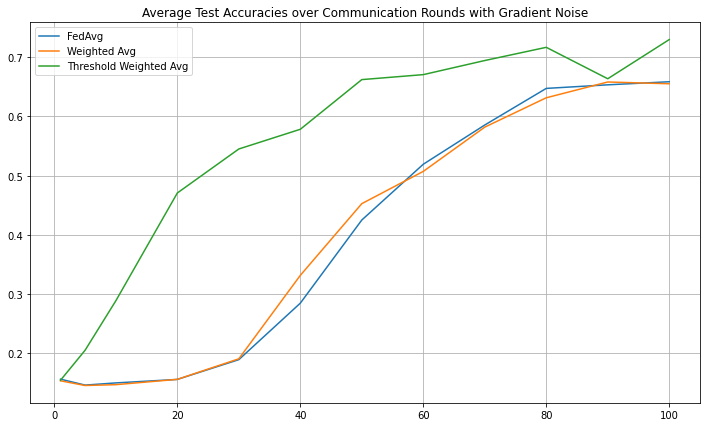

In [ ]:
#plotting the test accuracies

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.plot(communication_rounds, fed_avg_accs)
plt.plot(communication_rounds, weighted_avg_accs)
plt.plot(communication_rounds, threshold_accs)


plt.legend(["FedAvg", "Weighted Avg", "Threshold Weighted Avg"])
plt.grid()
plt.title("Average Test Accuracies over Communication Rounds with Gradient Noise")
plt.show()


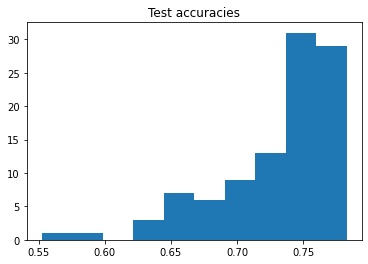

In [ ]:
#plot test accuracies
import matplotlib.pyplot as plt

plt.hist(test_accs)
plt.title("Test accuracies")
plt.show()

On Centralized Model

In [ ]:
# testing differential privacy model on centralized learning to see whether a similar improvement occurs

from torchcontrib.optim import SWA
import os
import networkx as nx
from torch.utils.data import DataLoader

cora_graph_training = nx.read_gml('cora_graph_training.gml')
test_graph = test_data

graph_nodes = list(cora_graph_training.nodes)
graph_nodes = [int(node) for node in graph_nodes]  # Convert to integer if they are not

graph_edge_index, _ = subgraph(graph_nodes, data.edge_index, relabel_nodes=True)
graph_data = Data(x=data.x[graph_nodes], edge_index=graph_edge_index, y=data.y[graph_nodes])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_test(graph_data, epochs, dataset, test_data, device):
    model  = GCN(graph_data.num_node_features, dataset.num_classes).to(device)
    private_model = DifferentiallyPrivateGCN(model, 0.01, 0.01)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    epochs = 10
    # Training loop for each epoch (adjust the range as needed)
    for epoch in range(1, epochs + 1):
        output, loss = private_model.train_step(graph_data.x, graph_data.edge_index, graph_data.y)
        train_losses.append(loss.item())
        val_loss, _ = validate(test_data, private_model, criterion)
        val_losses.append(val_loss)

    test_loss, test_acc = test(test_data, criterion, private_model)
    print("Centralized learning test accuracy: ", test_acc)

train_test(graph_data, 10, dataset, test_data, device)


Centralized learning test accuracy:  0.3226837060702875
